In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
tmdb = pd.read_csv('./data/tmdb-movies.csv', encoding='raw_unicode_escape')

This data set contains information about 10,000 movies collected from The Movie Database (TMDb), including user ratings and revenue.

- Certain columns, like ‘cast’ and ‘genres’, contain multiple values separated by pipe (|) characters.
- There are some odd characters in the ‘cast’ column. Don’t worry about cleaning them. You can leave them as is.
- The final two columns ending with “_adj” show the budget and revenue of the associated movie in terms of 2010 dollars, accounting for inflation over time.

In [3]:
def create_overview(df):
    # Function to create an aggregates overview from existing pandas methods for reuse
    # Use 'describe' and flip it for better readability
    overview = df.describe(include='all').T
    # Integrate dtypes
    overview['dtype'] = df.dtypes
    # Integrate an example (1st row)
    overview['example'] = df.head(1).T
    # % of items compared to dataset
    overview['complete_%'] = 100 * overview['count'] / df.shape[0]
    # Rename median
    overview.rename(index=str, columns={'50%': 'median'}, inplace=True)
    # Create new features (that, in 'describe', are normally only included with object columns)
    overview['top_alt'] = ''
    overview['freq_alt'] = 0
    overview['unique_alt'] = 0
    # Calculate new features
    for col in df.columns:
        value_counts = df[col].value_counts()
        overview.loc[col, 'top_alt'] = str(value_counts.index[0])
        overview.loc[col, 'freq_alt'] = value_counts.iloc[0]
        overview.loc[col, 'unique_alt'] = df[col].drop_duplicates().count()
    # Reorganize the overview (whilst neglecting some columns from 'describe')
    overview = overview[[
        # Example and dtype
        'example', 'dtype',
        # Number of items
        'count', 'complete_%', 'unique_alt',
        # Info about most frequent item
        'top_alt', 'freq_alt',
        # Some statistics
        'mean', 'std', 'min', 'median', 'max'
        ]]
    return overview

create_overview(tmdb)

,example,dtype,count,complete_%,unique_alt,top_alt,freq_alt,mean,std,min,median,max
id,135397,int64,10866,100,10865,42194,2,66064.2,92130.1,5,20669,417859
imdb_id,tt0369610,object,10856,99.908,10855,tt0411951,2,NaN,NaN,NaN,NaN,NaN
popularity,32.9858,float64,10866,100,10814,0.109305,2,0.646441,1.00018,6.5e-05,0.383856,32.9858
budget,150000000,int64,10866,100,557,0,5696,1.46257e+07,3.09132e+07,0,0,4.25e+08
revenue,1513528810,int64,10866,100,4702,0,6016,3.98233e+07,1.17003e+08,0,0,2.78151e+09
original_title,Jurassic World,object,10866,100,10571,Hamlet,4,NaN,NaN,NaN,NaN,NaN
cast,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,object,10790,99.3006,10719,Louis C.K.,6,NaN,NaN,NaN,NaN,NaN
homepage,http://www.jurassicworld.com/,object,2936,27.0201,2896,http://www.thehungergames.movie/,4,NaN,NaN,NaN,NaN,NaN
director,Colin Trevorrow,object,10822,99.5951,5067,Woody Allen,45,NaN,NaN,NaN,NaN,NaN
tagline,The park is open.,object,8042,74.0107,7997,Based on a true story.,5,NaN,NaN,NaN,NaN,NaN


Probably, this database has one duplicate row (max `count` = max `unique_alt` + 1 = 10.865).

However, before we dig a little deeper into the various features, it's useful to define the main purpose of the following analysis. This allows to focus on the features (hopefully) more relevant to this purpose.  

There are two aspects, we analyze this dataset here, whilst **focussing on "goodness" in terms of `'vote_average'`**
- How do "good movies" perform "economically" and how did this change over time?
- What are the artistic "ingredients" of a "good movie"? Especially, which genres and artists are the most "sucessful" ones?

Now, let's describe the fields, decide if they are being kept for the purposes of this special analysis, and describe, which issues are to be handled with in the data cleaning:  


| Field | Understanding & Assumptions | Keeper? | Issues |  
|:--- |:---|:---:|:---|  
| `'id'`  | Serves as an identifier | Yes | Convert to `str`, otherwise probably none |  
| `'imdb_id'` | Serves as an identifier | **No** | We take `'id'` instead | 
| `'popularity'` | Popularity rating for TMDB's website purposes (s. [here](https://developers.themoviedb.org/3/getting-started/popularity)) | **No** | Neglecting this feature | 
| `'budget'` | Film's budget in USD | Yes | Be aware of `0` values | 
| `'revenue'` | Film's revenue in USD | Yes | Be aware of `0` values | 
| `'original_title'` | Film title | Yes | Be aware of duplicates | 
| `'cast'` | Name of actors | Yes | Multiple items in a field and missing values | 
| `'homepage'` | Url | **No** | Neglecting this feature | 
| `'director'` | Name of director | Yes | Missing values | 
| `'tagline'` | Short description of film | **No** | Neglecting this feature, using `keywords` instead | 
| `'keywords'` | Tags for film description | Yes | Multiple items in a field and missing values | 
| `'overview'` | Longer description of film | **No** | Neglecting this feature, using `keywords` instead | 
| `'runtime'` | Runtime in minutes | Yes | Beware of `0` values | 
| `'genres'` | Tags for genre of film | Yes | Multiple items in a field and missing values | 
| `'production_companies'` | Name of production companies | Yes | Multiple items in a field and missing values | 
| `'release_date'` | Date of film release | Yes | to be transformed into `datetime` | 
| `'vote_count'` | ??? | Yes | Probably none | 
| `'vote_average'` | ??? | Yes | Probably none | 
| `'release_year'` | Year of film release | **No** | We take `'release_date'` instead| 
| `'budget_adj'` | Film's budget in USD (in 2018 prices) | Yes | Be aware of `0` values | 
| `'revenue_adj'` | Film's revenue in USD (in 2018 prices) | Yes | Be aware of `0` values | 

Unfortunatly, there are some encoding issues in the strings, I wasn't able to fix.

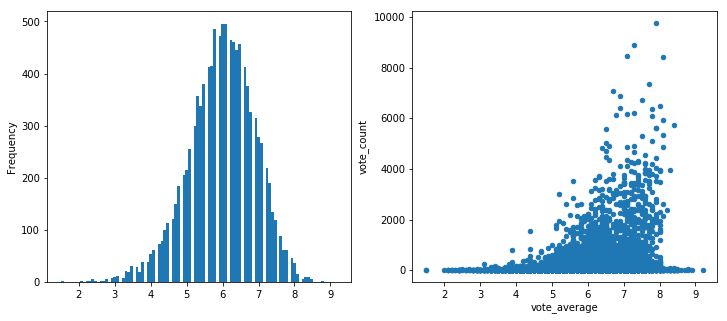

In [54]:
# First glance on 'vote_average' (and 'vote_count')

fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(12, 5))
tmdb.vote_average.plot.hist(bins=100, ax=ax1)
tmdb.plot.scatter(x='vote_average', y='vote_count', ax=ax2)
plt.show()

In [4]:
# Turning 'release_date' into 'datetime'

date = tmdb.release_date.str.split('/', expand=True)
day = date[1].astype(int)
month = date[0].astype(int)
year = tmdb.release_year
tmdb.release_date = pd.to_datetime((year*10000+month*100+day).apply(str), infer_datetime_format=True)

del date, day, month, year

In [5]:
# Turning id into (immutable) 'string'

tmdb.id = tmdb.id.astype(str)

In [6]:
# Dropping duplicates and neglected features

stmdb = tmdb.drop_duplicates(inplace=True)
stmdb.drop(axis=1, columns=['imdb_id', 'popularity', 'homepage', 'tagline', 'overview', 'release_year'], inplace=True)

In [7]:
# Analysing features containing 0 values in the next two cells

,id,budget,revenue,original_title,cast,director,keywords,runtime,genres,production_companies,release_date,vote_count,vote_average,budget_adj,revenue_adj,profit,profit_adj
3894,125336,NaN,NaN,The Story of Film: An Odyssey,Mark Cousins|Jean-Michel Frodon|Cari Beauchamp...,Mark Cousins,cinema|nouvelle vague|hindi cinema|cinema novo...,900.0,Documentary,NaN,2011-09-03,14,9.2,NaN,NaN,NaN,NaN
4041,150004,NaN,NaN,Taken,Dakota Fanning|Matt Frewer|Eric Close|Emily Be...,Breck Eisner|FÃÂ©lix EnrÃÂ­quez AlcalÃÂ¡|Jo...,NaN,877.0,Science Fiction,DreamWorks,2002-12-02,38,6.8,NaN,NaN,NaN,NaN
2722,331214,NaN,125000000.0,Band of Brothers,Damian Lewis|Ron Livingston|Frank John Hughes|...,Phil Alden Robinson|Richard Loncraine|Mikael S...,world war ii|us army|war|paratroops|combat,705.0,Action|Drama|War,HBO,2001-09-09,313,8.0,NaN,1.539360e+08,NaN,NaN
6176,42044,NaN,NaN,Shoah,Simon Srebnik|Michael Podchlebnik|Motke Zaidl,Claude Lanzmann,NaN,566.0,Documentary,British Broadcasting Corporation (BBC)|MinistÃ...,1985-11-01,16,8.3,NaN,NaN,NaN,NaN
6181,18729,NaN,NaN,"North and South, Book I",Patrick Swayze|Philip Casnoff|Kirstie Alley|Ge...,NaN,NaN,561.0,Drama|History|Western,NaN,1985-11-03,17,6.0,NaN,NaN,NaN,NaN


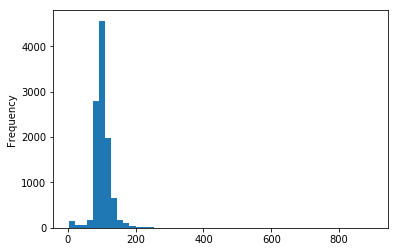

In [28]:
# Analysing runtime

tmdb.runtime.plot.hist(bins=50)
tmdb.loc[tmdb['runtime'] == 0, 'runtime'] = np.nan
tmdb.sort_values(by='runtime', ascending=False).head(5)

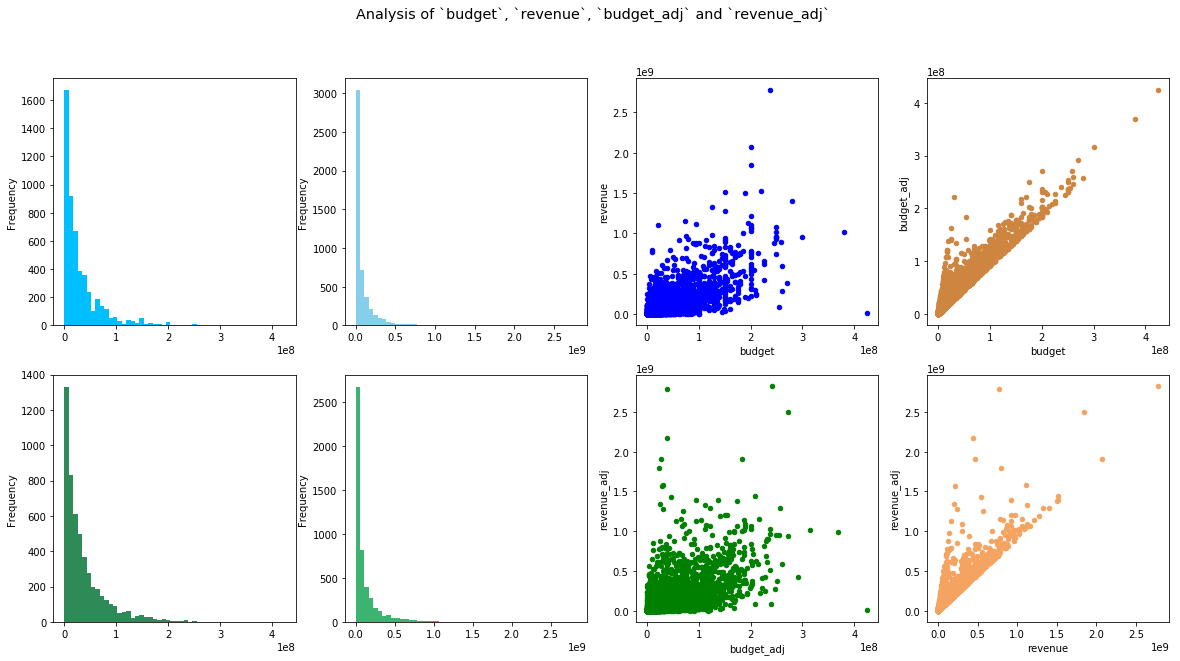

In [29]:
# Analysing `budget`, `revenue`, `budget_adj`, `revenue_adj`

fig, [[ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8]] = plt.subplots(
    nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle('Analysis of `budget`, `revenue`, `budget_adj` and `revenue_adj`', size='x-large')
# Histograms of `budget`, `revenue`, `budget_adj` and `revenue_adj`
tmdb['budget'].plot.hist(bins=50, ax=ax1, color='deepskyblue')
tmdb['revenue'].plot.hist(bins=50, ax=ax2, color='skyblue')
tmdb['budget_adj'].plot.hist(bins=50, ax=ax5, color='seagreen')
tmdb['revenue_adj'].plot.hist(bins=50, ax=ax6, color='mediumseagreen')
# Scatterplots of 'budget' vs. 'budget_adj' and 'revenue' vs. 'revenue_adj'
tmdb.plot.scatter(x='budget', y='revenue', ax=ax3, color='b')
tmdb.plot.scatter(x='budget_adj', y='revenue_adj', ax=ax7, color='g')
# Scatterplots of 'budget' vs. 'revenue' and 'budget_adj' vs. 'revenue_adj'
tmdb.plot.scatter(x='budget', y='budget_adj', ax=ax4, color='peru')
tmdb.plot.scatter(x='revenue', y='revenue_adj', ax=ax8, color='sandybrown')
plt.show()

In [32]:
# Turning `0` into NaN in `budget`, `revenue`, `budget_adj`and `revenue_adj` as 0 is implausible

tmdb.loc[tmdb['budget'] == 0, 'budget'] = np.nan
tmdb.loc[tmdb['revenue'] == 0, 'revenue'] = np.nan
tmdb.loc[tmdb['budget_adj'] == 0, 'budget_adj'] = np.nan
tmdb.loc[tmdb['revenue_adj'] == 0, 'revenue_adj'] = np.nan
print('\n',
      'Number of mismatches in `Nan` in `budget` and `budget_adj`:\t\t', (tmdb['budget'].isna() != tmdb['budget_adj'].isna()).sum(), '\n',
      'Number of mismatches in `Nan` in `revenue` and `revenue_adj`:\t\t', (tmdb['revenue'].isna() != tmdb['revenue_adj'].isna()).sum(), '\n',
      'Number of mismatches in `Nan` in `budget` and `revenue`:\t\t', (tmdb['budget'].isna() != tmdb['revenue'].isna()).sum(), '\n',
      'Number of mismatches in `Nan` in `budget_adj` and `revenue_adj`:\t', (tmdb['budget_adj'].isna() != tmdb['revenue_adj'].isna()).sum())


 Number of mismatches in `Nan` in `budget` and `budget_adj`:		 0 
 Number of mismatches in `Nan` in `revenue` and `revenue_adj`:		 0 
 Number of mismatches in `Nan` in `budget` and `revenue`:		 2310 
 Number of mismatches in `Nan` in `budget_adj` and `revenue_adj`:	 2310


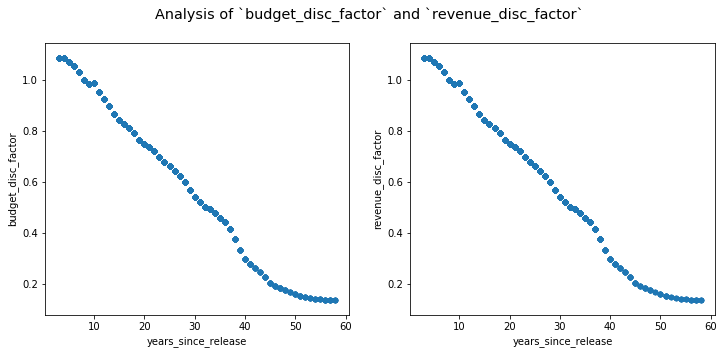

In [33]:
# Analysing discount factors in 'budget_adj' and 'revenue_adj'

discount_factor_df = tmdb[['budget', 'budget_adj', 'revenue', 'revenue_adj']].copy()
discount_factor_df['budget_disc_factor'] = discount_factor_df['budget'] / discount_factor_df['budget_adj']
discount_factor_df['revenue_disc_factor'] = discount_factor_df['revenue'] / discount_factor_df['revenue_adj']
discount_factor_df['years_since_release'] = 2018 - tmdb.release_date.dt.year.copy()

fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(12, 5))
fig.suptitle('Analysis of `budget_disc_factor` and `revenue_disc_factor`', size='x-large')
discount_factor_df.plot.scatter(x='years_since_release', y='budget_disc_factor', ax=ax1)
discount_factor_df.plot.scatter(x='years_since_release', y='revenue_disc_factor', ax=ax2)

del discount_factor_df

In [34]:
# Calculating 'profit' and 'profit_adj' as new derived feature

tmdb['profit'] = tmdb['revenue'] - tmdb['budget']
tmdb.loc[tmdb['budget'].isna() | tmdb['revenue'].isna(), 'profit'] = np.nan
tmdb['profit_adj'] = tmdb['revenue_adj'] - tmdb['budget_adj']
tmdb.loc[tmdb['budget_adj'].isna() | tmdb['revenue_adj'].isna(), 'profit_adj'] = np.nan

In [35]:
# Shortening and reorganizing columns for further analysis

stmdb = tmdb[
    [
        # Id and title
        'id', 'original_title', 
        # Rating data
        'vote_average',
        # Adjusted economical data
        'budget_adj', 'revenue_adj', 'profit_adj',
        # Release- and run-time
        'release_date', 'runtime', 
        # Genre and content/keywords tags
        'genres', 'keywords', 
        #Companies and people involved
        'production_companies', 'director', 'cast'
    
    ]
]

In [36]:
# Caring for columns with list like entries

# Creating a function to create an expanded dataframe from columns with list-like entries for later analysis
def expand_listlike_column_with_ids_long(df, id_col='', list_col='', pattern=''):
    # Function to create an expanded dataframe from list like entries for later reuse
    expanded = df[[id_col, list_col]].copy()
    expanded[list_col] = df[list_col].str.split(pat=pattern)
    # Borrowed from 'https://mikulskibartosz.name/how-to-split-a-list-inside-a-dataframe-cell-into-rows-in-pandas-9849d8ff2401'
    expanded = expanded[list_col].apply(pd.Series) \
        .merge(expanded, right_index = True, left_index = True) \
        .drop([list_col], axis = 1) \
        .melt(id_vars = [id_col], value_name = list_col) \
        .drop("variable", axis = 1) \
        .dropna() \
        .drop_duplicates()
    return expanded

# Just to see...
expand_listlike_column_with_ids_long(stmdb, 'id', 'genres', '|').head(5)

,id,genres
0,135397,Action
1,76341,Action
2,262500,Adventure
3,140607,Action
4,168259,Action


In [83]:
def build_sets_from_list(list_col):
    # Customized function to make several trafos and lists for further analysis
        # 'id_with_list_stats' will return a long dictionary of all film ids and list items
        # 'list_stats' will return statistics (averages) of all list items with relation to average votes etc.
        # 'id_with_list_stats' will return statistics (averages) of all id with relation to list stats
    
    # Create basic expanded list
    ids_with_list_long = expand_listlike_column_with_ids_long(stmdb, 'id', list_col, '|')
    
    # Defined for further focus (main quantitative columns in tmdb)
    _additional_stmdb_info = [
        # focusses on 'vote_average', but could be expanded
        'id',
        'vote_average', #'vote_count', 
        #'budget', 'revenue', 'profit', 
        #'budget_adj', 'revenue_adj', 'profit_adj',
        #'release_date', 'runtime'
    ]
    
    # Intermediate list with info from tmdb
    _list = pd.merge(ids_with_list_long, stmdb[_additional_stmdb_info], on='id', how='left')

    # Statistics on list (with info from tmdb)
    list_stats = _list.groupby(list_col).mean()
    
    # All crammed into one big (intermediate) list
    _list_with_ids_and_stats = pd.merge(_list, list_stats, on=list_col, how='left', suffixes=('', '_' + list_col))
    
    # Stats from genres for ids
    id_with_list_stats = _list_with_ids_and_stats.groupby('id').mean().iloc[:, 1:]
    # if more stats are of interest, iloc needs to be changed
    
    return ids_with_list_long, list_stats, id_with_list_stats

ids_with_genres_long, genres_stats, ids_with_genres_stats = build_sets_from_list('genres')
ids_with_keywords_long, keywords_stats, ids_with_keywords_stats = build_sets_from_list('keywords')
ids_with_prodcos_long, prodcos_stats, ids_with_prodcos_stats = build_sets_from_list('production_companies')
ids_with_directors_long, directors_stats, ids_with_directors_stats = build_sets_from_list('director')
ids_with_actors_long, actors_stats, ids_with_actors_stats = build_sets_from_list('cast')

# Just to see... (1/2)
genres_stats.head(5)

,vote_average
genres,
Action,5.787752
Adventure,5.940585
Animation,6.403147
Comedy,5.905167
Crime,6.124889


In [38]:
# Just to see... (2/2)
ids_with_genres_stats.head(5)

,vote_average_genres
id,
100,6.015028
10001,5.785375
10002,6.111103
10003,5.837493
10004,5.812798


In [55]:
def make_final_stmdb():
    stmdb1 = pd.merge(stmdb, ids_with_genres_stats, on='id', how='left')
    stmdb2 = pd.merge(stmdb1, ids_with_keywords_stats, on='id', how='left')
    stmdb3 = pd.merge(stmdb2, ids_with_prodcos_stats, on='id', how='left')
    stmdb4 = pd.merge(stmdb3, ids_with_directors_stats, on='id', how='left')
    stmdb_final = pd.merge(stmdb4, ids_with_actors_stats, on='id', how='left')
    return stmdb_final

atmdb = make_final_stmdb()

In [56]:
create_overview(atmdb)

,example,dtype,count,complete_%,unique_alt,top_alt,freq_alt,mean,std,min,median,max
id,135397,object,10865,100,10865,9825,1,NaN,NaN,NaN,NaN,NaN
original_title,Jurassic World,object,10865,100,10571,Hamlet,4,NaN,NaN,NaN,NaN,NaN
vote_average,6.5,float64,10865,100,72,6.1,496,5.97501,0.935138,1.5,6,9.2
budget_adj,1.38e+08,float64,5169,47.5748,2613,10164004.3412495,17,3.68891e+07,4.1961e+07,0.921091,2.27151e+07,4.25e+08
revenue_adj,1.39245e+09,float64,4849,44.6295,4839,57667591.0300945,2,1.15101e+08,1.98856e+08,2.37071,4.39567e+07,2.82712e+09
profit_adj,1.25445e+09,float64,3854,35.4717,3851,0.0,4,9.28247e+07,1.94071e+08,-4.13912e+08,2.73706e+07,2.75014e+09
release_date,2015-06-09 00:00:00,datetime64[ns],10865,100,5909,2009-01-01 00:00:00,28,NaN,NaN,NaN,NaN,NaN
runtime,124,float64,10834,99.7147,246,90.0,547,102.364,30.9482,2,99,900
genres,Action|Adventure|Science Fiction|Thriller,object,10842,99.7883,2039,Comedy,712,NaN,NaN,NaN,NaN,NaN
keywords,monster|dna|tyrannosaurus rex|velociraptor|island,object,9372,86.2586,8804,woman director,134,NaN,NaN,NaN,NaN,NaN


- Analyze 'economics'
 - Are (adjusted?) budgets, revenues and profits correlated to ratings?
- Analyze 'ingredients'
 - Which genres, keywords, prod_cos, directors, actors trigger the best ratings?
 - Are there 'dream combinations'? (e.g. average quality of actors, directors, prod_cos, genres, keywords correlated to ratings?)
- Answer some obvious/fun questions (best/worst film, actors in decline...) 

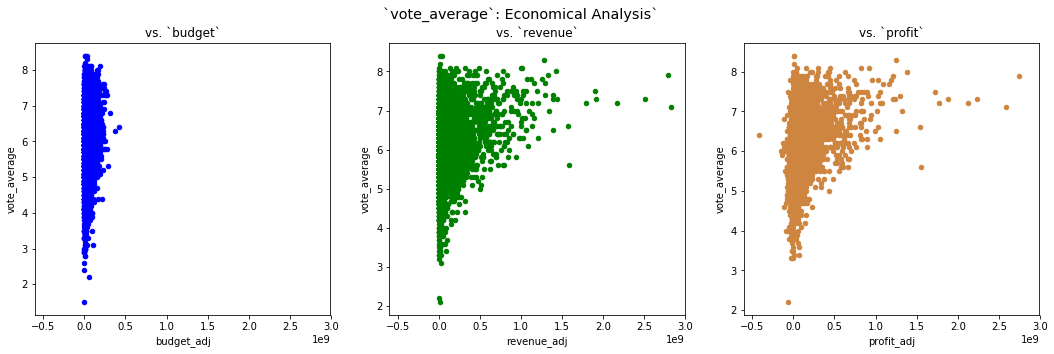

In [85]:
fig, [ax1, ax2, ax3] = plt.subplots(ncols=3, figsize=(18, 5), sharex=True)
fig.suptitle('`vote_average`: Economical Analysis`', size='x-large')
atmdb.plot.scatter(y='vote_average', x='budget_adj', ax=ax1, title='vs. `budget`', color='b')
atmdb.plot.scatter(y='vote_average', x='revenue_adj', ax=ax2, title='vs. `revenue`', color='g')
atmdb.plot.scatter(y='vote_average', x='profit_adj', ax=ax3, title='vs. `profit`', color='peru')
plt.show()

In [71]:
atmdb[atmdb.profit_adj == atmdb.profit_adj.min()].T

,2243
id,46528
original_title,The Warrior's Way
vote_average,6.4
budget_adj,4.25e+08
revenue_adj,1.10876e+07
profit_adj,-4.13912e+08
release_date,2010-12-02 00:00:00
runtime,100
genres,Adventure|Fantasy|Action|Western|Thriller
keywords,assassin|small town|revenge|deception|super speed


In [72]:
atmdb[atmdb.profit_adj == atmdb.profit_adj.max()].T

,1329
id,11
original_title,Star Wars
vote_average,7.9
budget_adj,3.95756e+07
revenue_adj,2.78971e+09
profit_adj,2.75014e+09
release_date,1977-03-20 00:00:00
runtime,121
genres,Adventure|Action|Science Fiction
keywords,android|galaxy|hermit|death star|lightsaber


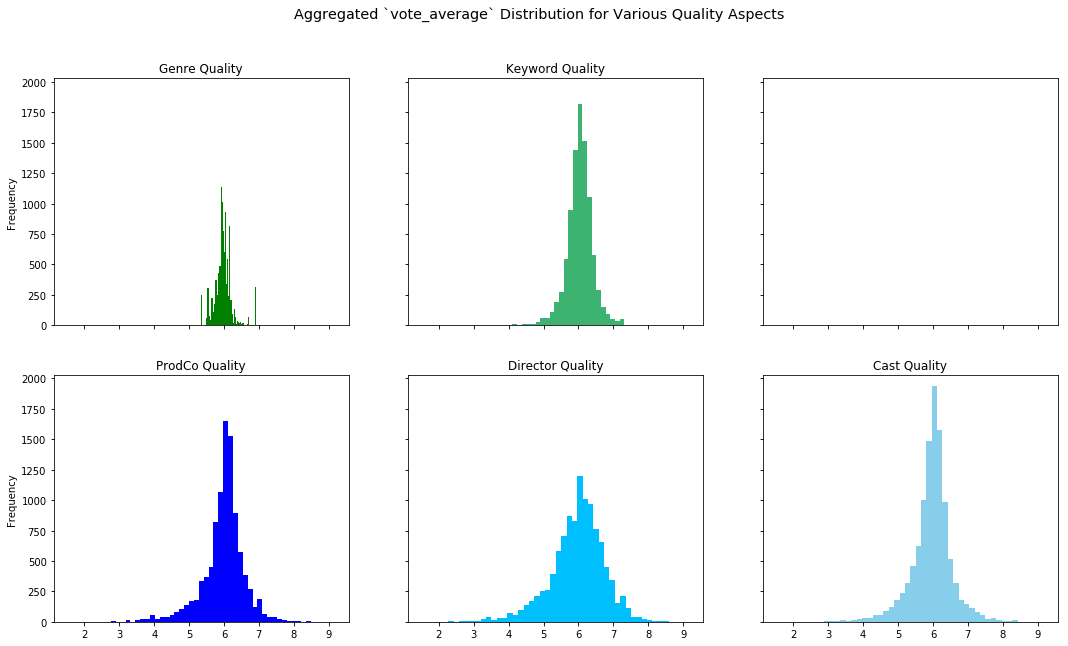

In [86]:
fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(18,10))
fig.suptitle('Aggregated `vote_average` Distribution for Various Quality Aspects' , size='x-large')
atmdb['vote_average_genres'].plot.hist(bins=50, ax=ax1, title='Genre Quality', color='g')
atmdb['vote_average_keywords'].plot.hist(bins=50, ax=ax2, title='Keyword Quality', color='mediumseagreen')
atmdb['vote_average_production_companies'].plot.hist(bins=50, ax=ax4, title='ProdCo Quality', color='b')
atmdb['vote_average_director'].plot.hist(bins=50, ax=ax5, title='Director Quality', color='deepskyblue')
atmdb['vote_average_cast'].plot.hist(bins=50, ax=ax6, title='Cast Quality', color='skyblue')
plt.show()

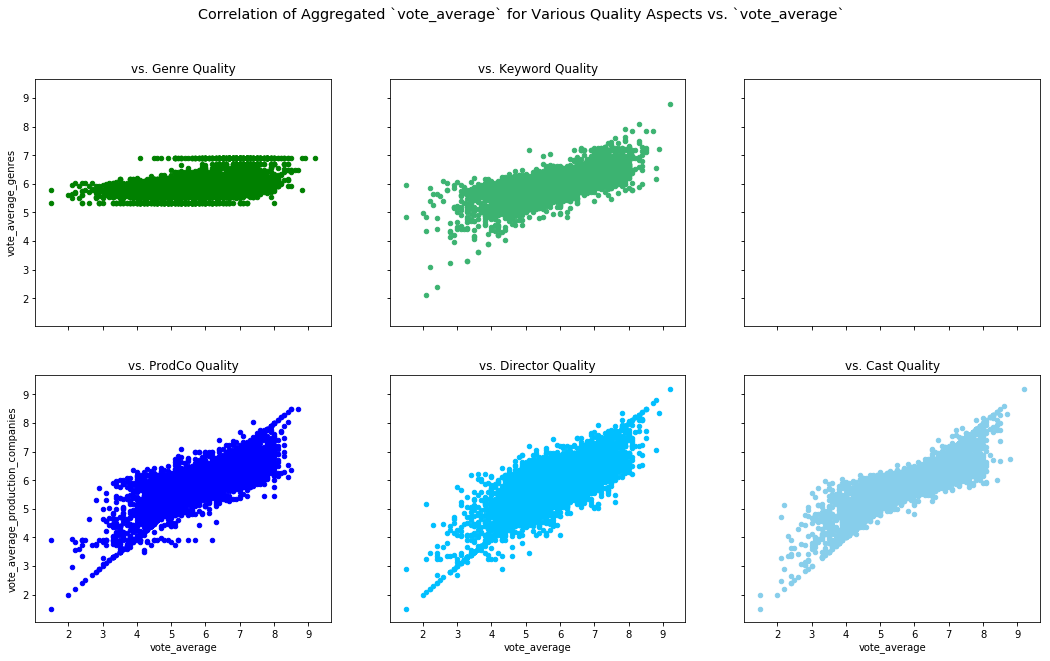

In [87]:
fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(18,10))
fig.suptitle('Correlation of Aggregated `vote_average` for Various Quality Aspects vs. `vote_average`' , size='x-large')
atmdb.plot.scatter(x='vote_average', y='vote_average_genres', ax=ax1, title='vs. Genre Quality', color='g')
atmdb.plot.scatter(x='vote_average', y='vote_average_keywords', ax=ax2, title='vs. Keyword Quality', color='mediumseagreen')
atmdb.plot.scatter(x='vote_average', y='vote_average_production_companies', ax=ax4, title='vs. ProdCo Quality', color='b')
atmdb.plot.scatter(x='vote_average', y='vote_average_director', ax=ax5, title='vs. Director Quality', color='deepskyblue')
atmdb.plot.scatter(x='vote_average', y='vote_average_cast', ax=ax6, title='vs. Cast Quality', color='skyblue')
plt.show()

In [112]:
genres_stats.sort_values(by='vote_average', ascending=False).head(5)

,vote_average
genres,
Documentary,6.908462
Music,6.480392
History,6.410479
Animation,6.403147
War,6.297778


In [113]:
genres_stats.sort_values(by='vote_average', ascending=False).tail(5)

,vote_average
genres,
TV Movie,5.788024
Action,5.787752
Thriller,5.750671
Science Fiction,5.665582
Horror,5.337447


In [114]:
keywords_stats.sort_values(by='vote_average', ascending=False).head()

,vote_average
keywords,
cinema novo,9.2
nouvelle vague,9.2
hindi cinema,9.2
russian cinema,9.2
misogyny,8.9


In [115]:
keywords_stats.sort_values(by='vote_average', ascending=False).tail()

,vote_average
keywords,
robot suits,2.2
scientific study,2.1
syfy,2.1
bird attack,2.1
nature run amok,2.1


In [116]:
prodcos_stats.sort_values(by='vote_average', ascending=False).head(5)

,vote_average
production_companies,
SMV Enterprises,8.7
EMI,8.7
Edel records GmbH,8.5
Red Bull Media House,8.5
Brain Farm Digital Cinema,8.5


In [117]:
prodcos_stats.sort_values(by='vote_average', ascending=False).tail(5)

,vote_average
production_companies,
Fiction Film & Television,2.3
Gamma Knife Films,2.2
Remember Dreaming Productions,2.1
Dudez Productions,2.0
Norm-Iris,1.5


In [118]:
directors_stats.sort_values(by='vote_average', ascending=False).head(5)

,vote_average
director,
Mark Cousins,9.2
Derek Frankowski,8.8
David Mallet,8.7
Michael Henry Wilson,8.5
Saul Swimmer,8.5


In [119]:
directors_stats.sort_values(by='vote_average', ascending=False).tail(5)

,vote_average
director,
Lawrence Kasanoff,2.2
Justin Russell,2.2
James Nguyen,2.1
Brett Kelly,2.0
Harold P. Warren,1.5


In [120]:
actors_stats.sort_values(by='vote_average', ascending=False).head(5)

,vote_average
cast,
Agnes de Mille,9.2
Jean-Michel Frodon,9.2
Mark Cousins,9.2
Cari Beauchamp,9.2
Oona Chaplin,8.8


In [121]:
actors_stats.sort_values(by='vote_average', ascending=False).tail(5)

,vote_average
cast,
Diane Mahree,1.5
Griff Furst,1.5
Shaley Scott,1.5
John Reynolds,1.5
Stephanie Nielson,1.5
